In [0]:
%matplotlib inline

In [0]:
import numpy as np
import numpy.linalg as npl
import pandas as pd

import sklearn.linear_model

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Noisy polynomials

In [0]:
def gen_data(n=10, sigma_noise=.2, sorted=True, fun='sin'):
    X = 2 * np.random.rand(1, n) - 1.0
    eps = np.random.randn(1, n) * sigma_noise
    if fun=='poly1':
        Y = 0.3 + .7*X + eps
    elif fun=='poly2':
        Y = 0.3 + .7*X -1.1*X**2 + eps
    elif fun =='log':
        Y = np.log(X+1)**.5 + eps
    elif fun == 'sin':
        Y = np.sin(2*np.pi*X) + eps
    else:
        raise ValueError(f"Unknown fun type: {fun}.")
    if sorted:
        xind = np.argsort(X[0, :])
        X= X[:, xind]
        Y= Y[:, xind]
    return X, Y


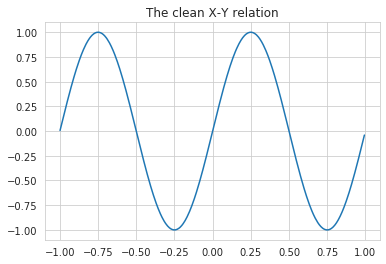

In [4]:
XC,YC = gen_data(n=1000, sigma_noise=0)
fig = plt.figure()
plt.plot(XC.T,YC.T,'-') #note: plot assumes that each column is a data series
plt.title('The clean X-Y relation')
plt.show()

In [0]:
def expandX(X, deg=1):
    return X**np.arange(deg + 1)[:, np.newaxis]

def expandRBF(X, N=100, sigma=1):
    Xmin = X.min()
    Xmax = X.max()
    return np.exp(-((np.linspace(Xmin, Xmax, N)[:, np.newaxis] - X) / sigma)**2)

def polyfit(X, Y, C=0.0):
    theta = npl.inv(X.dot(X.T) + np.eye(X.shape[0])*C).dot(X).dot(Y.T)
    return theta

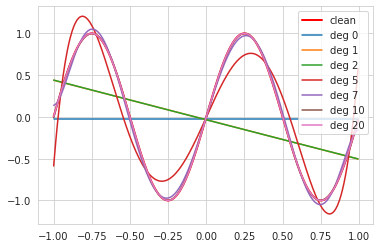

In [6]:
plt.figure()
plt.plot(XC.T,YC.T,'-r', linewidth=2, label='clean')
for deg in [0,1,2,5,7,10,20]:
    XE = expandX(XC,deg)
    #XE = expandRBF(XC,deg)
    theta = polyfit(XE, YC)
    plt.plot(XC.T, theta.T.dot(XE).T,'-', label='deg %d' % deg, )
plt.legend(loc='upper right')
plt.show()

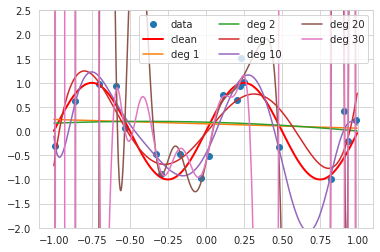

In [7]:
num = 20
lambda_ = 0

X,Y = gen_data(num, sigma_noise=0.4)
plt.figure()
plt.plot(X.T,Y.T,'o', label='data', alpha=1.0)
plt.plot(XC.T,YC.T,'-r', linewidth=2, label='clean')

for deg in [1, 2, 5, 10, 20, 30]:
    XE = expandX(X, deg)
    theta = polyfit(XE, Y, lambda_)
    plt.plot(XC.T, theta.T.dot(expandX(XC,deg)).T,'-', label='deg %d' % deg, )
plt.legend(loc='upper right', ncol=3)
plt.xlim([-1.1, 1.1])
plt.ylim([-2,2.5])
plt.show()

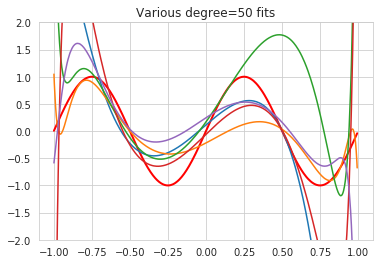

In [8]:
#Hint: change the degree and number of samples
deg = 50
num = 15
lambda_ = 1e-2

plt.figure()
plt.title('Various degree=%d fits' % deg)
plt.plot(XC.T, YC.T, '-r', linewidth=2, label='Clean rel.')
for run in range(5):
    X,Y = gen_data(num, sigma_noise=0.4)
    XE = expandX(X,deg)
    theta = polyfit(XE, Y, lambda_)
    XCE = expandX(XC,deg)
    plt.plot(XC.T, theta.T.dot(XCE).T,'-' )

plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.show()

# Outliers and robust regression

In [9]:
XC.shape

(1, 1000)

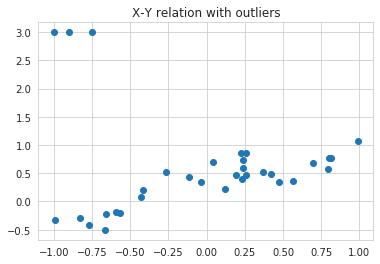

In [10]:
XC,YC = gen_data(n=30, sigma_noise=0.2, fun='poly1')
# now append some outliers

XO = np.concatenate([XC, [[-1, -0.9, -0.75]]], axis=1)
YO = np.concatenate([YC, [[3, 3, 3]]], axis=1)
fig = plt.figure()
plt.plot(XO.T,YO.T,'o') #note: plot assumes that each column is a data series
plt.title('X-Y relation with outliers')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


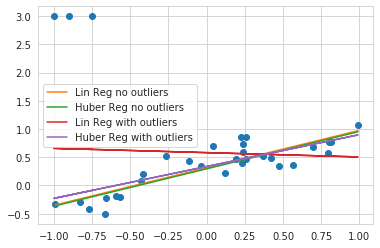

In [11]:
fig = plt.figure()
plt.plot(XO.T,YO.T,'o') #note: plot assumes that each column is a data series

XE = expandX(XC, 1)
poly = sklearn.linear_model.LinearRegression()
YFit = poly.fit(XE.T, YC.T)
plt.plot(XC.T, poly.predict(XE.T), label='Lin Reg no outliers')

poly = sklearn.linear_model.HuberRegressor()
YFit = poly.fit(XE.T, YC.T)
plt.plot(XC.T, poly.predict(XE.T), label='Huber Reg no outliers')

# Models on outliers
if 1:
    XE = expandX(XO, 1)
    poly = sklearn.linear_model.LinearRegression()
    YFit = poly.fit(XE.T, YO.T)
    plt.plot(XO.T, poly.predict(XE.T), label='Lin Reg with outliers')

    poly = sklearn.linear_model.HuberRegressor()
    YFit = poly.fit(XE.T, YO.T)
    plt.plot(XO.T, poly.predict(XE.T), label='Huber Reg with outliers')

_ = plt.legend()

# Forward stagewise

In [12]:
# Load the data

cancer_df = pd.read_csv(
    'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data',
    sep='\t', header=0, index_col=0)

train_id = cancer_df['train']
del cancer_df['train']

# Standardize the whole data, as per its readme
# https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.info.txt
# NB, usually you should standardize based on train set only!!

cancer_df -= cancer_df.mean(0, numeric_only=True)
cancer_df /= cancer_df.std(0, numeric_only=True)

cancer_train_df = cancer_df[train_id=='T']
cancer_test_df = cancer_df[train_id=='F']

X_cols = [c for c in cancer_df.columns if c!='lpsa']
Y_col = 'lpsa'

print(f'Train nas {len(cancer_train_df)} saples\n'
      f'Test nas {len(cancer_test_df)} saples')

cancer_train_df.head()

Train nas 67 saples
Test nas 30 saples


,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
1,-1.637356,-2.006212,-1.862426,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.520226
2,-1.988980,-0.722009,-0.787896,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.287827
3,-1.578819,-2.188784,1.361163,-1.024706,-0.522941,-0.863171,0.342627,-0.155348,-2.287827
4,-2.166917,-0.807994,-0.787896,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-2.287827
5,-0.507874,-0.458834,-0.250631,-1.024706,-0.522941,-0.863171,-1.042157,-0.864467,-1.825150


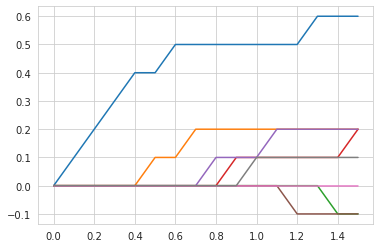

In [13]:
# Forward stagewise

epsilon = 1e-1
theta = np.zeros((len(X_cols),))
X = np.array(cancer_train_df[X_cols])
r = np.array(cancer_train_df[Y_col])

coefs = [np.array(theta)]
errs = []
last_err = np.sum(r**2)

for _ in range(1000000):
    # compute correlations
    residual_correlations = r @ X
    best_feat = np.argmax(np.abs(residual_correlations))
    max_corr = residual_correlations[best_feat]
    
    theta[best_feat] += epsilon * np.sign(max_corr)
    r -= epsilon * np.sign(max_corr) * X[:, best_feat]
    cur_err = np.sum(r**2)

    if last_err - cur_err < 0:
        break
    last_err = cur_err
    errs.append(cur_err)
    coefs.append(np.array(theta))


coefs = np.array(coefs).T
tau = np.abs(coefs).sum(0)

for i, name in enumerate(X_cols):
    plt.plot(tau, coefs[i], label=name)
#_ = plt.legend()

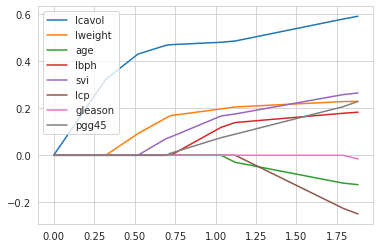

In [14]:
#@title  Lasso LARS

(alphas, active, coefs
 ) = sklearn.linear_model.lars_path(np.array(cancer_train_df[X_cols]), 
                                    np.array(cancer_train_df[Y_col]))
 
# coefs is D x n_steps
tau = np.abs(coefs).sum(0)

for i, name in enumerate(X_cols):
    plt.plot(tau, coefs[i], label=name)
_ = plt.legend()